# Load packages and Install "aletheia-dnn" (if needed)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import make_scorer, roc_auc_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

# !pip install aletheia-dnn
from aletheia import *

# Load synthetic data and Train ReLU DNN

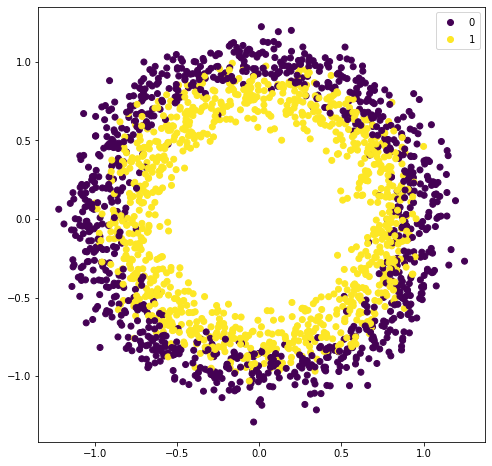

In [2]:
random_state = 0

x, y = make_circles(n_samples=2000, noise=0.1, random_state=random_state)
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

plt.figure(figsize=(8,8))
scatter = plt.scatter(x[:, 0], x[:, 1], c=y)
plt.legend(*scatter.legend_elements(), loc="upper right")
plt.show()

In [3]:
mlp = MLPClassifier(hidden_layer_sizes=[40] * 4, max_iter=2000, early_stopping=True, 
                    n_iter_no_change=100, validation_fraction=0.2,
                    solver='adam', activation="relu", random_state=random_state, 
                    learning_rate_init=0.001)
mlp.fit(train_x, train_y)
print("Training AUC:", roc_auc_score(train_y, mlp.predict_proba(train_x)[:,1]).round(4))
print("Testing AUC:", roc_auc_score(test_y, mlp.predict_proba(test_x)[:,1]).round(4))

Training AUC: 0.9215
Testing AUC: 0.932


# Unwrapper and Visualization

In [4]:
clf = UnwrapperClassifier(mlp.coefs_, mlp.intercepts_)
clf.fit(train_x, train_y)

In [5]:
clf.summary()

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,62.0,0.532258,0.498958,0.736677,0.497650
1,60.0,0.600000,0.489898,0.915509,0.496326
2,52.0,0.480769,0.499630,0.828148,0.502093
3,31.0,0.516129,0.499740,0.800000,0.496405
4,29.0,0.655172,0.475312,0.810526,0.504409
...,...,...,...,...,...
525,1.0,1.000000,0.000000,NaN,0.501199
526,1.0,0.000000,0.000000,NaN,0.497572
527,1.0,1.000000,0.000000,NaN,0.503097
528,1.0,0.000000,0.000000,NaN,0.498530


In [6]:
# Percentage of Dummy LLMs
len(np.where(clf.ystd_llms == 0)[0]) / clf.nllms

0.8490566037735849

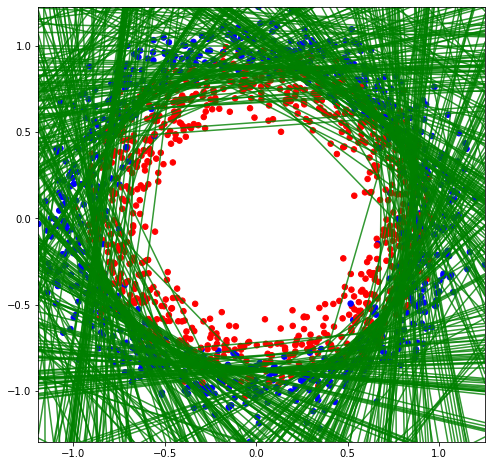

In [7]:
# Plot of LLMs in 2D case
fig = clf.visualize2D_lines(figsize=(8, 8))

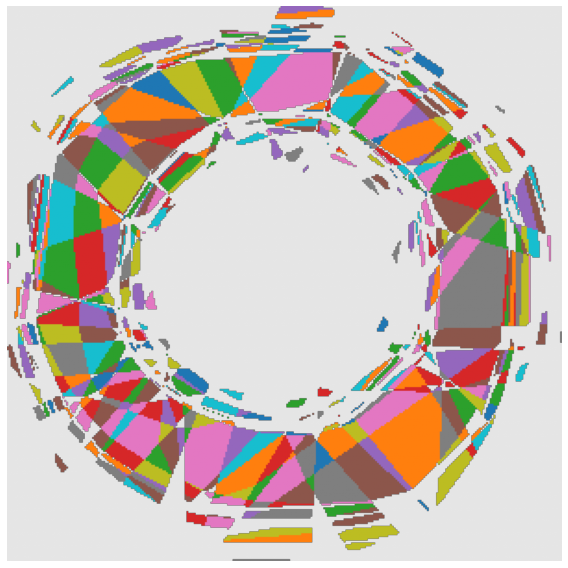

In [8]:
# Visualization of regions in 2D case
fig = clf.visualize2D_regions(figsize=(8, 8), meshsize=300, show_label=False)

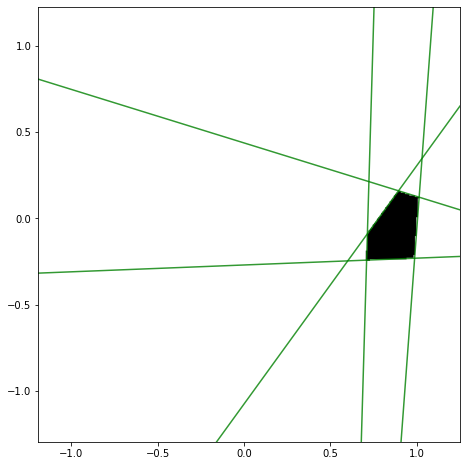

In [9]:
# Identification of region boundary (2D demo)
fig = clf.visualize2D_one_region(conf_id=0, figsize=(8, 8))

In [10]:
# Polar plot of LLM coefficients (Using PCA for dimensionality 2+)
# fig = clf.polar_plot(min_samples=16, figsize=(8, 8))

# Interpretation and Diagnostics

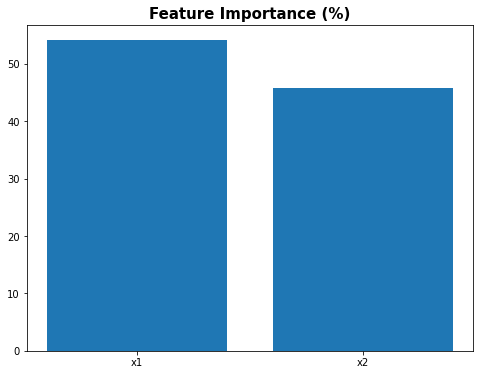

In [11]:
# Feature importance plot
fig = clf.feature_importance_plot(figsize=(8, 6))

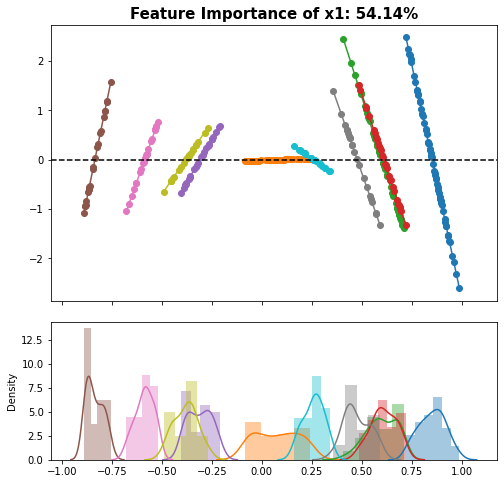

In [12]:
# Local linear profile plot
fig = clf.profile_plot(feature_id=1, figsize=(8, 8))

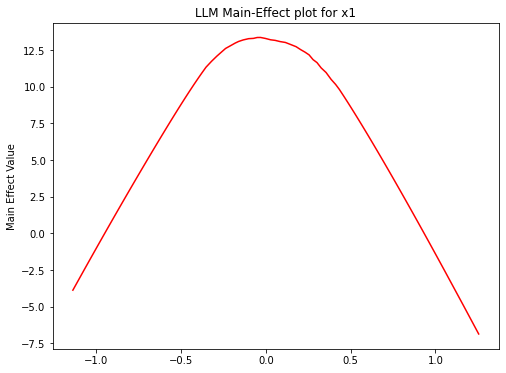

In [13]:
# Main-effect plot
fig = clf.partial_plot(feature_id=1, figsize=(8, 6))

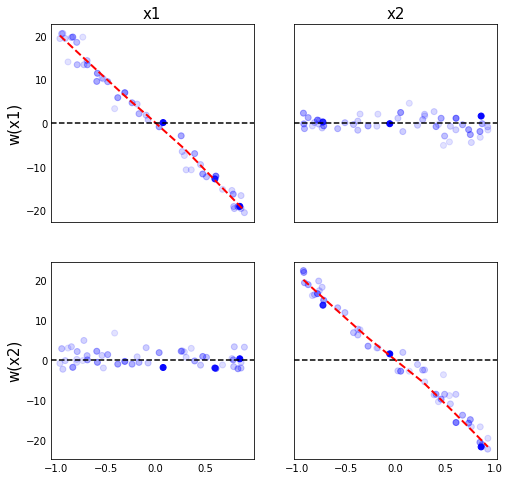

In [14]:
# Pairwise-interaction plot 
# for checking nonlinearlity (diagonal) and interactions (off-diagonal)
fig = clf.pair_plot(feature_idx=[1, 2], nllms=50, figsize=(8, 8), offdiagsmooth=False)

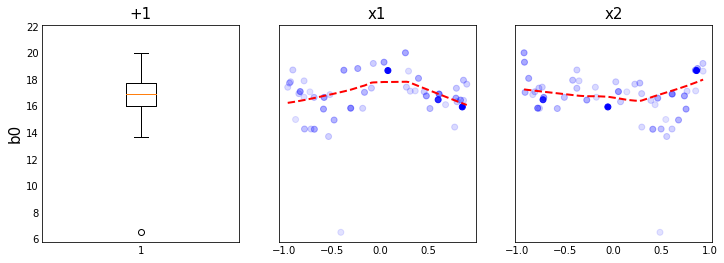

In [15]:
# Intercept plot 
fig = clf.intercept_plot(feature_idx=[1, 2], nllms=50)

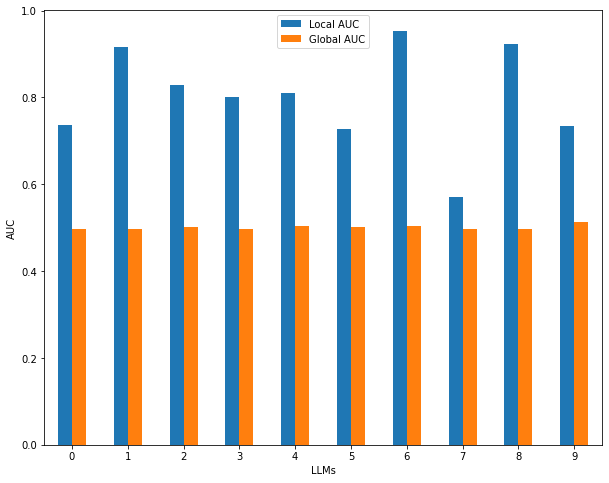

In [16]:
# Local vs. Global perofrmance diagnostics 
fig = clf.diagperf_bar(nllms=10, figsize=(10, 8))

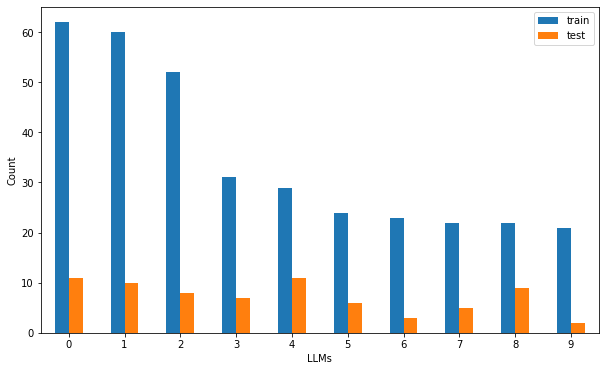

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,11.0,0.636364,0.481046,0.928571,0.496144
1,10.0,0.500000,0.500000,1.000000,0.533316
2,8.0,0.250000,0.433013,0.583333,0.468825
3,7.0,0.714286,0.451754,1.000000,0.517265
4,11.0,0.454545,0.497930,0.833333,0.474785
5,6.0,0.666667,0.471405,0.750000,0.505371
6,3.0,0.666667,0.471405,1.000000,0.482222
7,5.0,0.800000,0.400000,0.750000,0.518204
8,9.0,0.222222,0.415740,0.714286,0.532139
9,2.0,0.000000,0.000000,NaN,0.475110


In [17]:
# Exposure of top regions to training and test datasets 
restable, fig = clf.evaluate(test_x, test_y, nllms=10)
restable.head(10)

# Simplification

In [18]:
## Run the merging algorithm
datanum = train_x.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=random_state)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1

grid = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=mlp.coefs_, 
                                     biases=mlp.intercepts_,
                                     min_samples=30,
                                     n_neighbors=np.round(clf.nllms * 0.01).astype(int),
                                     refit_model=LogisticRegression()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", n_jobs=10, error_score=np.nan)
grid.fit(train_x, train_y)
clf_merge = grid.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,252.0,0.543651,0.498091,0.921866,0.503503
1,226.0,0.721239,0.448390,0.959587,0.498833
2,206.0,0.441748,0.496595,0.861730,0.496401
3,203.0,0.527094,0.499265,0.911604,0.497495
4,187.0,0.401070,0.490115,0.859167,0.505026
5,186.0,0.548387,0.497653,0.914916,0.500703
6,173.0,0.393064,0.488431,0.900840,0.495534
7,167.0,0.389222,0.487574,0.909653,0.502008


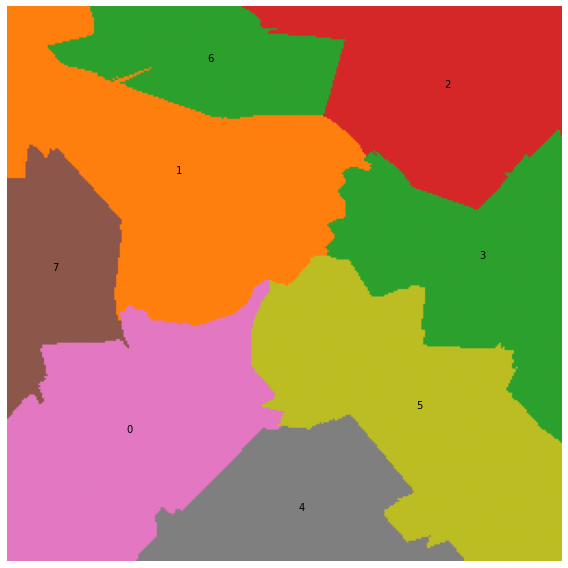

In [19]:
# Visualization of merged regions in 2D case
fig = clf_merge.visualize2D_regions(figsize=(8, 8), meshsize=300, show_label=True)

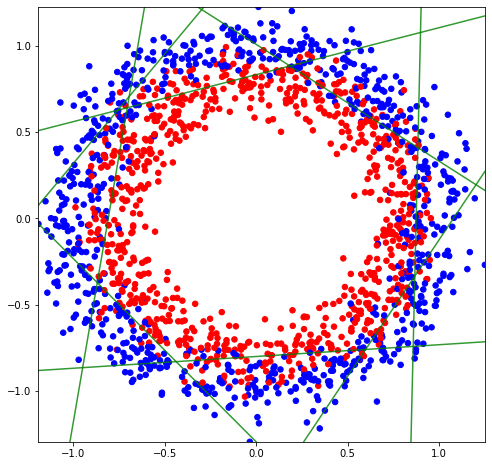

In [20]:
# Plot of merged LLMs (refitted) in 2D case
fig = clf_merge.visualize2D_lines(figsize=(8, 8))

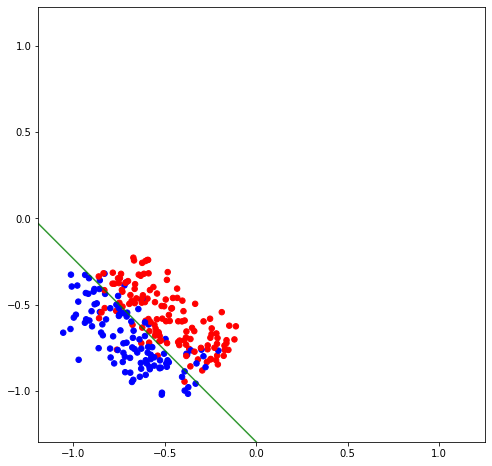

In [21]:
tmpid = 0
fig = clf_merge.visualize2D_one_line(tmpid, figsize=(8, 8))

In [22]:
restable = clf_merge.local_inference_wald(tmpid).round(4)
restable

Count            252.000000
Response Mean      0.543651
Response Std       0.498091
Local AUC          0.921866
Global AUC         0.503503
Name: 0, dtype: float64


,coef,std err,z,p-value,[0.025,0.975]
b0,5.3201,0.9076,5.8616,0.0,3.5412,7.0990
x1,4.3638,0.7963,5.4802,0.0,2.8031,5.9245
x2,4.1135,0.8906,4.6188,0.0,2.3679,5.8590


Count            252.000000
Response Mean      0.543651
Response Std       0.498091
Local AUC          0.921866
Global AUC         0.503503
Name: 0, dtype: float64


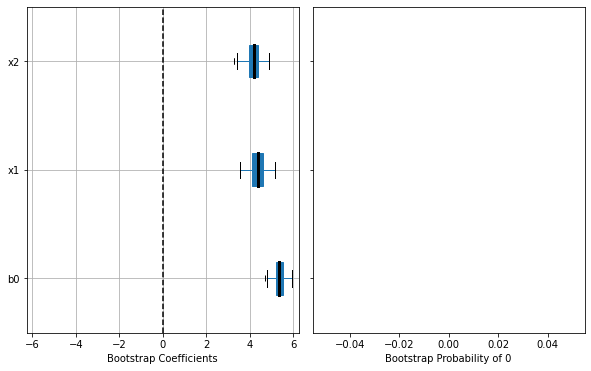

In [23]:
fig = clf_merge.local_inference_bootstrap(tmpid)

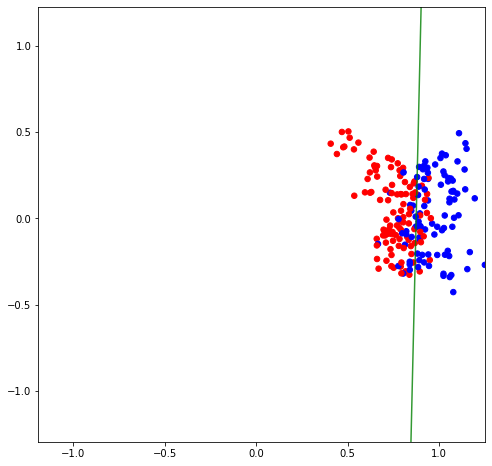

In [24]:
tmpid = 3
fig = clf_merge.visualize2D_one_line(tmpid, figsize=(8, 8))

In [25]:
restable = clf_merge.local_inference_wald(tmpid).round(4)
restable

Count            203.000000
Response Mean      0.527094
Response Std       0.499265
Local AUC          0.911604
Global AUC         0.497495
Name: 3, dtype: float64


,coef,std err,z,p-value,[0.025,0.975]
b0,4.5311,0.9523,4.7581,0.000,2.6646,6.3975
x1,-5.1829,1.0952,-4.7325,0.000,-7.3294,-3.0364
x2,0.1143,0.7207,0.1585,0.874,-1.2982,1.5267


Count            203.000000
Response Mean      0.527094
Response Std       0.499265
Local AUC          0.911604
Global AUC         0.497495
Name: 3, dtype: float64


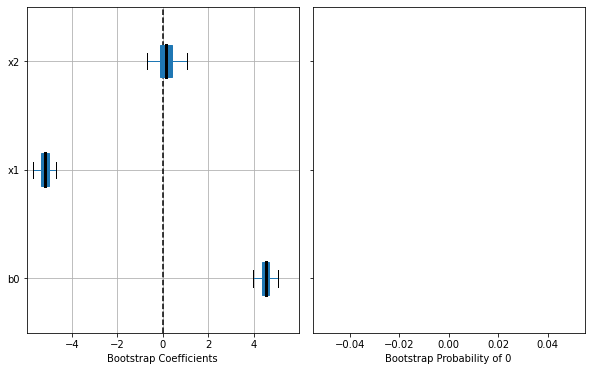

In [26]:
fig = clf_merge.local_inference_bootstrap(tmpid)

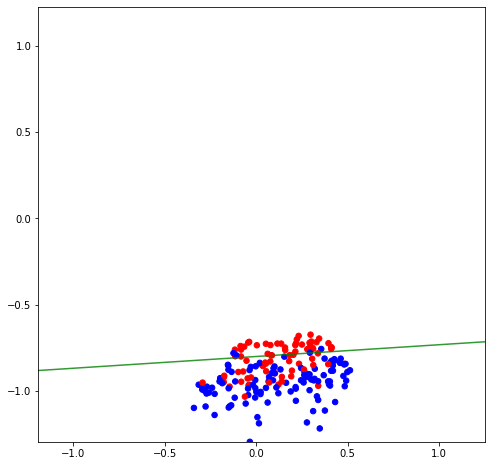

In [27]:
tmpid = 4
fig = clf_merge.visualize2D_one_line(tmpid, figsize=(8, 8))

In [28]:
restable = clf_merge.local_inference_wald(tmpid).round(4)
restable

Count            187.000000
Response Mean      0.401070
Response Std       0.490115
Local AUC          0.859167
Global AUC         0.505026
Name: 4, dtype: float64


,coef,std err,z,p-value,[0.025,0.975]
b0,3.1957,1.3261,2.4099,0.0160,0.5966,5.7948
x1,-0.2724,0.7277,-0.3744,0.7081,-1.6987,1.1538
x2,3.9995,1.4558,2.7472,0.0060,1.1461,6.8529


Count            187.000000
Response Mean      0.401070
Response Std       0.490115
Local AUC          0.859167
Global AUC         0.505026
Name: 4, dtype: float64


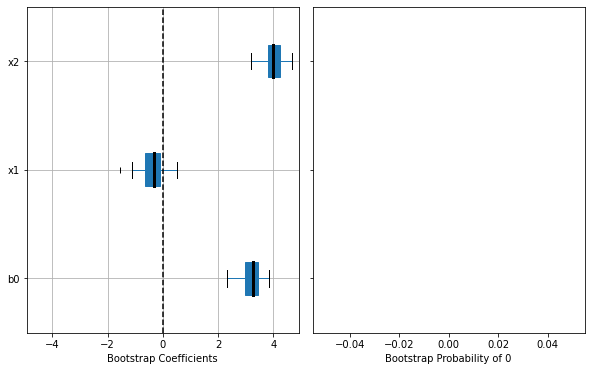

In [29]:
fig = clf_merge.local_inference_bootstrap(tmpid)

# Performance Comparision: ReLU-Net, Pruner, Merger, Merger + Flatterner 

In [30]:
# Perform simple pruning of the original net
clf_prune = PrunerClassifier(unwrapper=clf, topk=np.sum(clf.count_llms > 10), refit_model=LogisticRegression())
clf_prune.fit(train_x, train_y)

In [31]:
# Perform flattening on the merged net
clf_flatten = clf_merge.flatten(refit_model=LogisticRegression(C=1e10))
clf_flatten.fit(train_x, train_y)

In [32]:
# Compare the performance 
train_stat = pd.DataFrame(np.hstack([roc_auc_score(train_y, mlp.predict_proba(train_x)[:, 1]),
           roc_auc_score(train_y, clf_prune.predict_proba(train_x)[:, 1]),
           roc_auc_score(train_y, clf_merge.predict_proba(train_x)[:, 1]),
           roc_auc_score(train_y, clf_flatten.predict_proba(train_x)[:, 1])]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["train"]).T
test_stat = pd.DataFrame(np.hstack([roc_auc_score(test_y, mlp.predict_proba(test_x)[:, 1]),
           roc_auc_score(test_y, clf_prune.predict_proba(test_x)[:, 1]),
           roc_auc_score(test_y, clf_merge.predict_proba(test_x)[:, 1]),
           roc_auc_score(test_y, clf_flatten.predict_proba(test_x)[:, 1])]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Prune,Merge,Flatten
train,0.9215,0.7990,0.9002,0.9016
test,0.9320,0.7739,0.9015,0.9094
